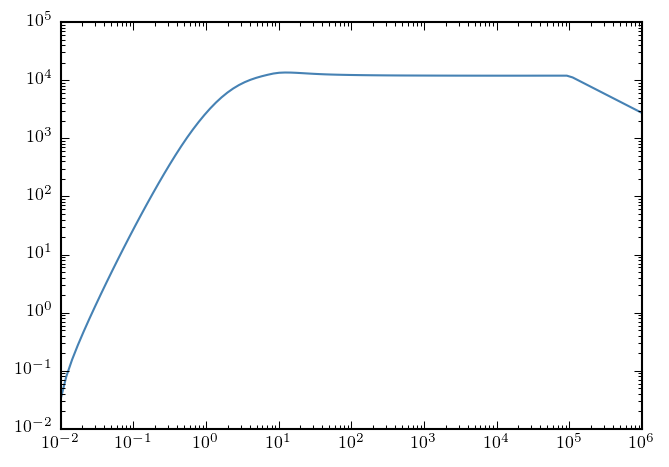

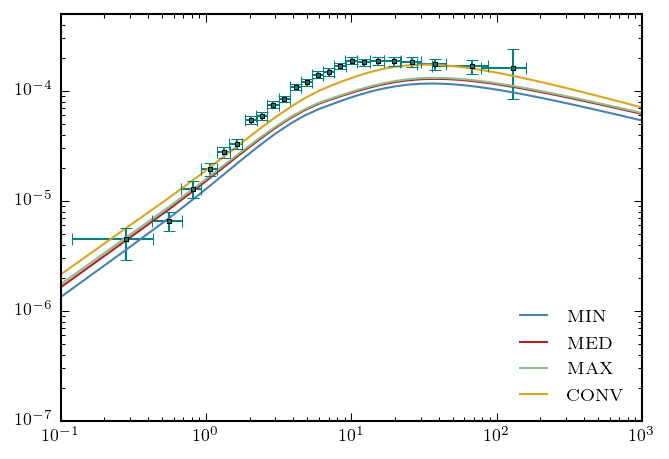

In [30]:
import pyfits
import prop

def getGalpropNuclei(fits,A,Z,R=8.5):
    """
    Given a galprop 3d nuclear file (non-full), return the energy and spectrum.
    
    :param fits: path to the nuclear data fits file
    :param A: Atomic number of desired nucleus  
    :param Z: Atomic charge of desired nucelus.  All species meeting A,Z will be summed
    :param R: The desired radius to evaluate the spectrum. Linearly interpolated over grid
    :returns energies, spectrum: energies in GeV, spectrum in (GeV/nuc)^2 (m^2 sr s GeV/nuc)^-1 
    """
    # open the fits file
    hdu = pyfits.open(fits)
    
    hdr = hdu[0].header
    
    # Build list of radii and energies based on header keywords.
    r_list = np.linspace(hdr['CRVAL1'],hdr['CRVAL1']+(hdr['NAXIS1']-1)*hdr['CDELT1'],hdr['NAXIS1'])
    energies = 10.**np.linspace(hdr['CRVAL3'],hdr['CRVAL3']+(hdr['NAXIS3']-1)*hdr['CDELT3'],hdr['NAXIS3'])
    
    # Build a list of the nuclei
    A_list, Z_list = [], []
    for nucIndex in range(hdr['NAXIS4']):
        nucString = ('%.3f' % ((nucIndex+1)/1000.))[-3:]
        A_list.append(hdr['NUCA'+nucString])
        Z_list.append(hdr['NUCZ'+nucString])
        
    A_list = np.array(A_list)
    Z_list = np.array(Z_list)
    
    z_idx = np.abs(hdr['CRVAL2'])/hdr['CDELT2']
    
    # Linearly interpolate spectra in radius.
    i_r2 = np.argmax(r_list>R) # finds the first element at r>R
    i_r1 = i_r2-1 # finds the next smallest radius.
    dr = r_list[i_r2]-r_list[i_r1]
    w1 = (r_list[i_r2]-R)/dr # weight for spectrum i_r1
    w2 = 1.-w1 # weight for spectrum i_r2
    
    master = np.zeros(hdu[0].shape[1])
    # Find which indices contain A,Z requested.  Could be more than one since primary and secondary are specified. 
    idx = np.where((A_list==A) & (Z_list==Z))[0]
    
    if len(idx)==0:
        raise Exception('No nuclei found with A,Z='+str(A)+','+str(Z))
    for i in idx:
        master += w1*hdu[0].data[i,:,z_idx,i_r1]
        master += w2*hdu[0].data[i,:,z_idx,i_r2]
  
    return energies/1e3, master*1e4/energies**2*1e3



def readCRDB(filename):
    tmp = np.genfromtxt(filename, skip_header=8)
    
    type_ = tmp[:,12]
    idx = np.where(type_==1.1)[0]
    
    e, ep, em = tmp[idx,5:8].T
    v, vp, vm = tmp[idx,8:11].T
    Z = tmp[idx,16].T
    return e,ep-e,e-em,v,vp,vm,Z


import pandas as pd
def ReadCoogDudeCSV():
    data = pd.read_csv('./antiprotons.csv')
    return data['e'], data['ratio'], data['error_high']-data['ratio']
def AMSProtonSpectrum():
    data = pd.read_csv('./protons.csv')
    return data['e'], data['ratio'], data['error_high']-data['ratio']




clrs = ['steelblue', 'firebrick','darkseagreen', 'goldenrod']
# for i, model in enumerate(('MIN', 'MED', 'MAX', 'CONV')):
#     T, flux_p = getGalpropNuclei(fits='/data/galprop2/output/nuclei_full_54_jin_etal_'+model+'.gz', A=1, Z=1)
#     T, flux_pbar = getGalpropNuclei(fits='/data/galprop2/output/nuclei_full_54_jin_etal_'+model+'.gz', A=1, Z=-1)
    
#     T, flux_p = prop.applyForceField(T, flux_p, phi=0.5, A=1, Z=1, m=.938)
#     T, flux_pbar = prop.applyForceField(T, flux_pbar, phi=0.5, A=1, Z=1, m=.938)
    
#     plt.loglog(T, T**2.7*flux_p, label=model, linestyle='-', c=clrs[i])
#     plt.loglog(T, T**2.7*flux_pbar, linestyle=':', c=clrs[i])

# plt.ylim(1e-7, 1e10)    
# plt.legend(frameon=False)
# plt.show()


T, flux_p = getGalpropNuclei(fits='/data/galprop2/output/nuclei_full_54_jin_etal_'+model+'.gz', A=1, Z=1)
plt.loglog(T,T**2.7*p)
plt.show()


for i, model in enumerate(('MIN', 'MED', 'MAX', 'CONV')):
    T, flux_p = getGalpropNuclei(fits='/data/galprop2/output/nuclei_full_54_jin_etal_'+model+'.gz', A=1, Z=1)
    T, flux_pbar = getGalpropNuclei(fits='/data/galprop2/output/nuclei_full_54_jin_etal_'+model+'.gz', A=1, Z=-1)
    
    T, flux_p = prop.applyForceField(T, flux_p, phi=0.55, A=1, Z=1, m=.938)
    T, flux_pbar = prop.applyForceField(T, flux_pbar, phi=0.55, A=1, Z=1, m=.938)
    
    plt.loglog(T, flux_pbar/flux_p, label=model, linestyle='-', c=clrs[i])
    
# Plot PAMELA DATA 
e,el,eh,v,vp,vm,Z = readCRDB(filename='PAMELA_pbar_ratio.dat',)
plt.errorbar(e, v, xerr=(el, eh), yerr=(vm, vp), linestyle='', marker='s', markersize=2, color=None)

e_ams, ratio_ams, error_ams = ReadCoogDudeCSV()
    
plt.xlim(1e-1, 1e3)
plt.ylim(1e-7, 5e-4)
plt.legend(frameon=False, loc=4)
plt.show()




In [32]:

from iminuit import Minuit
def fitData(model_e, model_p, model_pbar, data_e, mu, sigma):
    
    
    def f(a, phi):
        T, flux_p = prop.applyForceField(model_e, model_p, phi=phi, A=1, Z=1, m=.938)
        T, flux_pbar = prop.applyForceField(model_e, model_pbar, phi=phi, A=1, Z=1, m=.938)
        
        new_model=np.interp(data_e, T, flux_pbar/flux_p)
        counts = a*new_model
        
        negLogLike = np.sum(0.5*np.log(2*np.pi*sigma**2) + (counts-mu)**2/(2.*sigma**2))
        return negLogLike
    
    m = Minuit(f, errordef=0.5,print_level=1,a=1., phi=.55, fix_phi=True)
    
    m.migrad()
    
    #res = (f, x0=0, args=(new_model, mu, sigma), options={'disp':False})
    
    return m




/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.


FCN = -149.336122326 
 TOTAL NCALL = 15 
 NCALLS = 15 
 
 
 EDM = 2.77000071577e-20 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,1.880428e+00,1.777564e-02,0.000000e+00,0.000000e+00,,,
2,phi,5.500000e-01,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED


/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.


FCN = -176.764138369 
 TOTAL NCALL = 15 
 NCALLS = 15 
 
 
 EDM = 1.11126880891e-19 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,1.695390e+00,1.598734e-02,0.000000e+00,0.000000e+00,,,
2,phi,5.500000e-01,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED


/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.


FCN = -184.720346175 
 TOTAL NCALL = 13 
 NCALLS = 13 
 
 
 EDM = 3.54906815153e-19 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,1.659110e+00,1.563417e-02,0.000000e+00,0.000000e+00,,,
2,phi,5.500000e-01,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED


/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.


FCN = -141.057707262 
 TOTAL NCALL = 13 
 NCALLS = 13 
 
 
 EDM = 1.28242718172e-19 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,1.277025e+00,1.208062e-02,0.000000e+00,0.000000e+00,,,
2,phi,5.500000e-01,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED


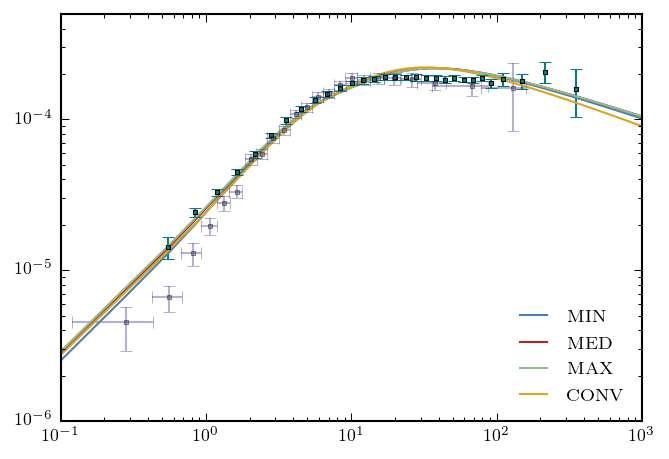

In [33]:
for i, model in enumerate(('MIN', 'MED', 'MAX', 'CONV')):

    T, flux_p = getGalpropNuclei(fits='/data/galprop2/output/nuclei_full_54_jin_etal_'+model+'.gz', A=1, Z=1)
    T, flux_pbar = getGalpropNuclei(fits='/data/galprop2/output/nuclei_full_54_jin_etal_'+model+'.gz', A=1, Z=-1)
    
    e_ams, ratio_ams, error_ams = ReadCoogDudeCSV()
    #m = fitData(T,flux_p, flux_pbar,e,v,vp) # PAMELA FIT 
    m = fitData(T,flux_p, flux_pbar,e_ams, ratio_ams, error_ams) # AMS-02 2015 Fit
    a = m.values['a']
    
    T, flux_p = prop.applyForceField(T, flux_p, phi=m.values['phi'], A=1, Z=1, m=.938)
    T, flux_pbar = prop.applyForceField(T, flux_pbar, phi=m.values['phi'], A=1, Z=1, m=.938)
    
    #drawing it nicely
#     m.draw_mncontour('a','phi', nsigma=3);
#     plt.show()
    
    plt.loglog(T, a*flux_pbar/flux_p, label=model, linestyle='-', c=clrs[i])
    
    #plt.show()

    
    
e,el,eh,v,vp,vm,Z = readCRDB(filename='PAMELA_pbar_ratio.dat',)
plt.errorbar(e_ams, ratio_ams, yerr=error_ams, linestyle='', marker='s', markersize=2, color=None)
plt.errorbar(e, v, xerr=(el, eh), yerr=(vm, vp), linestyle='', marker='s', markersize=2, color=None, alpha=.4)
plt.xlim(1e-1, 1e3)
plt.ylim(1e-6, 5e-4)
plt.legend(frameon=False, loc=4)   
    
# Plot PAMELA DATA 


    



In [4]:
# ----------------------------------------------------------------
# PL Interpolate PPPC4DM Antiproton data
# ----------------------------------------------------------------

from scipy.interpolate import RegularGridInterpolator as rpi
import pandas as pd 

# Read in the PPPC4DM injection spectra 
dm = pd.read_csv('AtProduction_antiprotons.dat', delim_whitespace=True)
m_dm, x_dm, inj_b = dm['mDM'], dm['Log[10,x]'],dm['b'], 

# Reduce the list to a set 
dm_list = sort(list(set(m_dm))) 

X_DM = np.linspace(-8.9,0,8.9/.05+1) # Spacing in x=T/m_chi corresponding to PPPC4DM

# Loop over the rows and fill in the interpolation grid. (Power-law interpolation)
grid_data = np.zeros((len(dm_list), len(X_DM)))  # Init the grid
for i_m, m in enumerate(dm_list):
    idx = np.where(m_dm==m)[0]
    grid_data[i_m] = np.log10(inj_b[idx])

# Build the interpolator and a function to call it.
interp = rpi((np.log10(dm_list),X_DM), grid_data, bounds_error=False, fill_value=0.)
inj_spectrum_interp = lambda m: 10**interp((np.log10(m),X_DM), method='linear')

# # Test the interpolator 
# def PlotPbar(m):
#     inj = inj_spectrum_interp(m)
#     plt.loglog(10**X_DM, inj)

# for m in 10**np.arange(1,5):
#     PlotPbar(m)  

    
kpc2cm, Myr2sec = 3.08567758e21, 31557600000000.
def PPPC4DM_prop(T, dNdT, m_chi, species, model='MED',halo='NFW', sigma_v=3e-26, rho_dm=0.39, prop_func_directory='/data/propagation_functions/'):
    '''
    2-zone diffusion Green Functions for antiprotons and antideuterons min/med/max interstellar propagation assuming an annihilating profiles. 
    Based on pppc4dm http://www.marcocirelli.net/PPPC4DMID.html  + arXiv: 1412.5696

    :params T: Kinetic energy per nucleon [GeV/n]
    :params dNdT: differential count per (Kinetic energy per nucleon) [dbar / (GeV/n)^-1]
    :params m_chi: mass of DM candidate in GeV
    :params species: can be 'antiprotons' or 'antideuterons' 
    :params model: Propagation model: 'MIN', 'MED', 'MAX'
    :params halo: DM Halo model: 'NFW', 'Moo', 'Iso', 'Ein', 'EiB', 'Bur'
    :params sigma_v: Thermal cross-section in cm^3/s
    :params rho_dm: Local dark matter density in GeV^-3
    :prop_func_directory: Directory containing the propagation functions from http://www.marcocirelli.net/PPPC4DMID.html
    
    :returns: [T,dNdT]: Kinetic energy per nucleon in GeV/n, Differential Interstellar CR flux in m^-2 s^-1 sr^-1 (GeV/n)^-1
    '''
    # Load the propagation functions from file 
    with open(prop_func_directory + '/Propagation_Ann_R' + species + '.dat') as f: 
        for line in f:
            if halo in line and model in line:
                a = np.array(line.split()[2:]).astype(np.float32)
    
    # This is the propagation function defined by 1412.5696v3 eq14
    prop_function = lambda T: 10**(np.sum([a[i]*np.log10(T)**i for i in range(6)],axis=0))
    
    # Lorentz factors of particle (T is per nucleon so no need to multiply proton mass by A)
    gamma = T/0.938+1.
    # Velocity of particle in cm/s 
    v_p = np.sqrt(1-1/gamma**2)* 2.9979e10
    
    # Rescale based on DM parameters
    #rescaling = v_p/(4*np.pi) * (rho_dm/0.39)**2 * (100./m_chi)**2 * (sigma_v/3e-26) * Myr2sec

    rescaling = v_p/(4*np.pi) * (rho_dm/m_chi)**2 * sigma_v / 2.
    return T, rescaling*prop_function(T)*Myr2sec*dNdT *1e4 # 1e4 to convert from cm^-2 to m^-2



def applyForceField(T_IS,flux,phi=.500, Z=2,A=1,m=2*.938):
    """
    Applies the force-field approximation to the interstellar spectrum passed in. 
    
    :params T_IS: Interstellar Kinetic Energies in GeV
    :params flux: dnde in arb/GeV
    :params phi: Fisk potential in GV
    :params Z: Atomic charge
    :params A: Atomic mass number (for electrons/positron leave A=1 and set m=m_e)
    :params m: particle mass in GeV
    :returns T_TOA, Flux_TOA: Kinetic Energy and dnde at the top of atmosphere. 
    """
    flux_IS = lambda x: np.interp(x, T_IS, flux)
    T_TOA = T_IS-phi*np.abs(Z)/A
    return T_TOA, (2*m*A*T_TOA+(A*T_TOA)**2)/(2*m*A*T_IS+(A*T_IS)**2)*flux_IS(T_IS)


def DMFlux(m_chi,sigma_v):
    # Get antiproton flux from PPPC4DM, propagate, and apply solar modulation 
    T, dNdT = 10**X_DM*m_chi, inj_spectrum_interp(m_chi)
    dNdT = np.nan_to_num(dNdT)
    T, dNdT = PPPC4DM_prop(T, dNdT, m_chi, species='antiprotons',rho_dm=0.3)
    T, dNdT = applyForceField(T,dNdT, phi=.55,A=1,Z=1,m=0.938)
    return T, sigma_v*dNdT
    
    


In [5]:
%timeit DMFlux(m_chi=10.,sigma_v=1)

1000 loops, best of 3: 588 µs per loop


FCN = 758.629511475 
 TOTAL NCALL = 1 
 NCALLS = 1 
 
 
 EDM = 758.629511475 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,phi,5.500000e-01,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,m_chi,1.090000e+04,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,sigma_v,1.133333e-01,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED


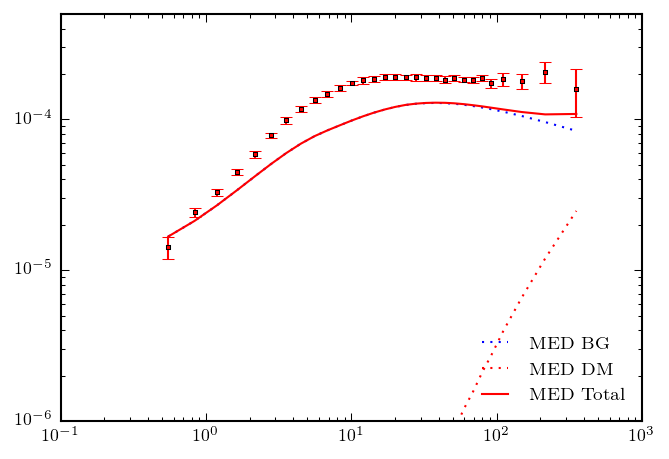

In [40]:

def ModelCounts(model_e, model_p, model_pbar, data_e, mu, sigma, a, phi, m_chi,sigma_v):
        
        # Background 
        T, flux_p = prop.applyForceField(model_e, model_p, phi=phi, A=1, Z=1, m=.938)
        T, flux_pbar = prop.applyForceField(model_e, model_pbar, phi=phi, A=1, Z=1, m=.938)
        new_model=np.interp(data_e, T, flux_pbar/flux_p)
        new_p=lambda e: np.interp(e, T, flux_p)
        
        # DM fitting
        T_DM, flux_DM = DMFlux(m_chi,sigma_v)
        new_dm=np.interp(data_e, T_DM, flux_DM/new_p(T_DM), left=0, right=0)
        
        # Add them up
        counts = a*new_model + new_dm
        return  counts, new_dm, a*new_model

    
def fitData_bb(model_e, model_p, model_pbar, data_e, mu, sigma):
    """
    """
    def f(a, phi,m_chi,sigma_v):
        counts = ModelCounts(model_e, model_p, model_pbar, data_e, mu, sigma,a, phi,m_chi,sigma_v)[0]
        negLogLike = np.sum(0.5*np.log(2*np.pi*sigma**2) + (counts-mu)**2/(2.*sigma**2))
        return negLogLike
    
    m = Minuit(f, errordef=0.5,print_level=1,a=1., phi=.55, fix_phi=True, m_chi=10.9e3, sigma_v=3.4e2/3./1e3, fix_sigma_v=True, fix_m_chi=True,fix_a=True)
    m.migrad()
    return m



for i, model in enumerate(('MED',)):

    T, flux_p = getGalpropNuclei(fits='/data/galprop2/output/nuclei_full_54_jin_etal_'+model+'.gz', A=1, Z=1)
    T, flux_pbar = getGalpropNuclei(fits='/data/galprop2/output/nuclei_full_54_jin_etal_'+model+'.gz', A=1, Z=-1)
    
    e_ams, ratio_ams, error_ams = ReadCoogDudeCSV()
    #m = fitData(T,flux_p, flux_pbar,e,v,vp) # PAMELA FIT 
    m = fitData_bb(T,flux_p, flux_pbar,e_ams, ratio_ams, error_ams) # AMS-02 2015 Fit
    
    T, flux_p = prop.applyForceField(T, flux_p, phi=m.values['phi'], A=1, Z=1, m=.938)
    T, flux_pbar = prop.applyForceField(T, flux_pbar, phi=m.values['phi'], A=1, Z=1, m=.938)
    
    #drawing it nicely
#     m.draw_mncontour('a','phi', nsigma=3);
#     plt.show()
    
    #plt.loglog(T, m.values['a']*flux_pbar/flux_p, label=model, linestyle=':', c=clrs[i])
    T_DM, flux_DM = DMFlux(m_chi=m.values['m_chi'], sigma_v=m.values['sigma_v'])
    
    #print ModelCounts(T,flux_p, flux_pbar,e_ams, ratio_ams, error_ams,**m.values)
    
    total, DM, BG = ModelCounts(T,flux_p, flux_pbar,e_ams, ratio_ams, error_ams,**m.values)
    
    #total, BG, DM = ModelCounts(T,flux_p, flux_pbar,e_ams, ratio_ams, error_ams,a=1, phi=.55, m_chi=100.,sigma_v=1.)
    
    plt.loglog(e_ams, BG , label=model + ' BG', linestyle=':', c='b')
    plt.loglog(e_ams, DM , label=model + ' DM', linestyle=':', c='r')
    plt.loglog(e_ams, total , label=model + ' Total', linestyle='-', c='r')
    
    
e,el,eh,v,vp,vm,Z = readCRDB(filename='PAMELA_pbar_ratio.dat',)
plt.errorbar(e_ams, ratio_ams, yerr=error_ams, linestyle='', marker='s', markersize=2, color='r')
#plt.errorbar(e, v, xerr=(el, eh), yerr=(vm, vp), linestyle='', marker='s', markersize=2, color='b', alpha=.4) # PAMELA
plt.xlim(1e-1, 1e3)
plt.ylim(1e-6, 5e-4)
plt.legend(frameon=False, loc=4)   

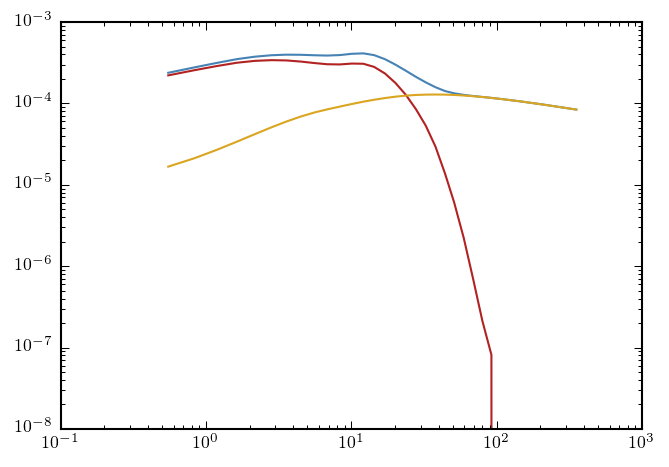

In [7]:


def ModelCounts(model_e, model_p, model_pbar, data_e, mu, sigma, a, phi, m_chi,sigma_v):
        
        # Background 
        T, flux_p = prop.applyForceField(model_e, model_p, phi=phi, A=1, Z=1, m=.938)
        T, flux_pbar = prop.applyForceField(model_e, model_pbar, phi=phi, A=1, Z=1, m=.938)
        new_model=np.interp(data_e, T, flux_pbar/flux_p)
        new_p=lambda e: np.interp(e, T, flux_p)
        
        # DM fitting
        T_DM, flux_DM = DMFlux(m_chi,sigma_v)
        new_dm=np.interp(data_e, T_DM, flux_DM/new_p(T_DM), left=0, right=0)
        
        # Add them up
        counts = a*new_model + new_dm
        return  counts, new_dm, a*new_model



f1, f2, f3 = ModelCounts(T,flux_p, flux_pbar,e_ams, ratio_ams, error_ams,a=1, phi=.55, m_chi=100.,sigma_v=1.)

plt.loglog(e_ams,f1)
plt.loglog(e_ams,f2)
plt.loglog(e_ams,f3)
plt.yscale('log')
plt.xscale('log')

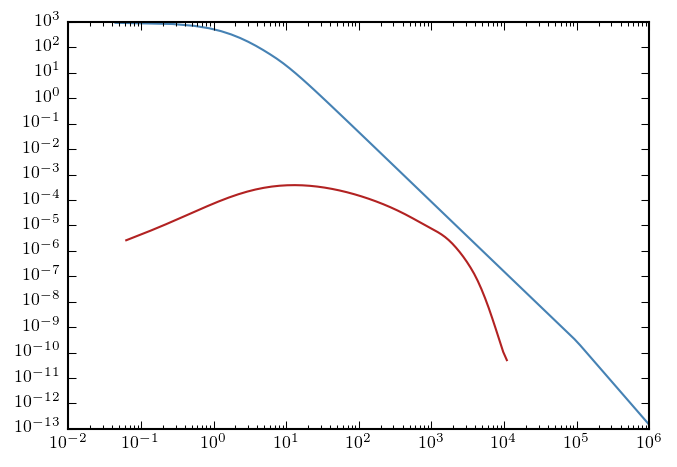

(1e-06, 0.0005)

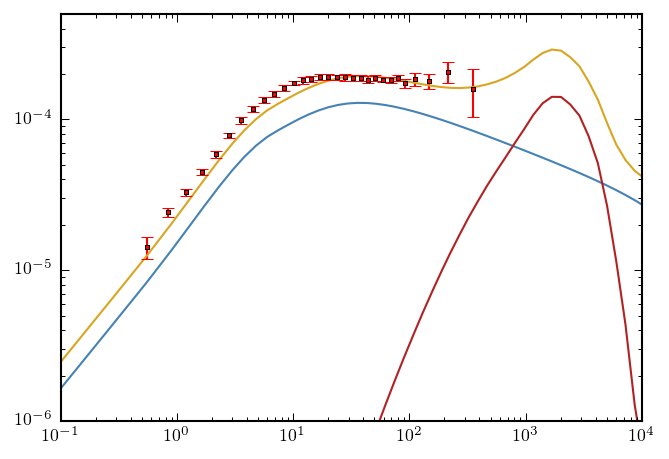

In [47]:
plt.loglog(T,flux_p)
T_DM, f_DM = DMFlux(m_chi=10.9e3, sigma_v = 3.4e-24/3e-26)
plt.loglog(T_DM,f_DM)
plt.show()


plt.loglog(T,flux_pbar/flux_p)
DM_interp = np.interp(T, T_DM, f_DM,left=0,right=0)

plt.loglog(T,DM_interp/flux_p/1e3)
plt.loglog(T,(flux_pbar+DM_interp/1e3)/flux_p*1.5)
plt.errorbar(e_ams, ratio_ams, yerr=error_ams, linestyle='', marker='s', markersize=2, color='r')
plt.xlim(1e-1,1e4)
plt.ylim(1e-6,5e-4)
